## Trying to investigate overfitting and see if regularization, or early stopping can help
Want to look at overfitting wrt to a few decoding attempts, specifically:
- rule dim decoding
- feature decoding of rule dim

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import utils.visualization_utils as visualization_utils

import os
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
from utils.session_data import SessionData

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor, NormedDropoutNonlinear

from trial_splitters.rule_condition_block_splitter import RuleConditionBlockSplitter


PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

rule_to_dim = {
    'CIRCLE': 'SHAPE', 
    'SQUARE': 'SHAPE', 
    'STAR': 'SHAPE', 
    'TRIANGLE': 'SHAPE', 
    'CYAN': 'COLOR', 
    'GREEN': 'COLOR', 
    'MAGENTA': 'COLOR', 
    'YELLOW': 'COLOR', 
    'ESCHER': 'PATTERN', 
    'POLKADOT': 'PATTERN', 
    'RIPPLE': 'PATTERN', 
    'SWIRL': 'PATTERN'
}

feature_dims = ["COLOR", "SHAPE", "PATTERN"]

## Look at rule dim decoding

### plot train test accs on already trained models

In [2]:
pseudo_train = np.load(f"/data/patrick_scratch/pseudo/rule_dim_train_accs.npy")
pseudo_test = np.load(f"/data/patrick_scratch/pseudo/rule_dim_test_accs.npy")

Text(0, 0.5, 'Decoder Accuracy')

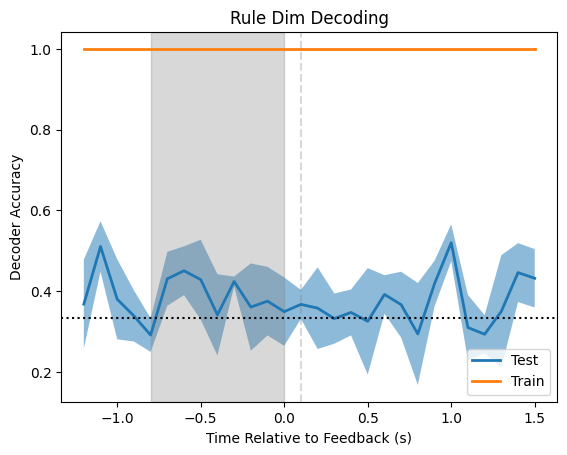

In [3]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_test,
    1.3, 1.5, 0.1,
    ax,
    label=f"Test",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_train,
    1.3, 1.5, 0.1,
    ax,
    label=f"Train",
    right_align=True, 
)
ax.legend()
ax.set_title(f"Rule Dim Decoding")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.333, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### Look at a specific series of training epochs during rule dim decoding

In [4]:
def create_session_data(sess_name):
    behavior_path = f"/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
    beh = pd.read_csv(behavior_path)
    valid_beh = beh[(beh.Response.isin(["Correct", "Incorrect"])) & (beh.BlockNumber >= 2)]  
    valid_beh["RuleDim"] = valid_beh.apply(lambda x: rule_to_dim[x.CurrentRule], axis=1)
    # trials = behavioral_utils.get_last_n_corrects_per_block(valid_beh, 5)
    trials = behavioral_utils.get_last_n_corrects_per_block(valid_beh, 8)
    frs = pd.read_pickle(f"/data/patrick_scratch/multi_sess/{sess_name}/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins.pickle")
    splitter = RuleConditionBlockSplitter(trials, condition="RuleDim", num_distinct_conditions=3)
    return SessionData(sess_name, trials, frs, splitter)

def check_sess(x):
    sess_name = x.session_name
    behavior_path = f"/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
    beh = pd.read_csv(behavior_path)
    last_block = beh.BlockNumber.max()
    valid_beh = beh[
        (beh.Response.isin(["Correct", "Incorrect"])) & 
        (beh.BlockNumber >= 2) &
        (beh.BlockNumber != last_block) 
    ]  
    valid_beh["RuleDim"] = valid_beh.apply(lambda x: rule_to_dim[x.CurrentRule], axis=1)

    grouped_blocks = valid_beh.groupby(by="RuleDim").apply(lambda x: len(x.BlockNumber.unique()) >=4)
    at_least_two = np.all(grouped_blocks)
    return at_least_two


In [5]:
valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions.pickle")
print(f"number of valid sessions: {len(valid_sess)}")
valid_sess["satisfy"] = valid_sess.apply(check_sess, axis=1)
valid_sess = valid_sess[valid_sess.satisfy]
print(f"number of sessions that satisfy criteria: {len(valid_sess)}")

number of valid sessions: 36
number of sessions that satisfy criteria: 34


In [6]:
sess_datas = valid_sess.apply(lambda x: create_session_data(x.session_name), axis=1)

num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
print(f"{num_neurons} neurons to decode with")
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(feature_dims)}
trainer = Trainer(learning_rate=0.01, max_iter=1000, batch_size=1000)
model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, feature_dims)

1045 neurons to decode with
cuda


In [7]:
time_bin = 0.7
pseudo_sess = pd.concat(sess_datas.apply(
    lambda x: x.generate_pseudo_data(500, 100, time_bin)
).values, ignore_index=True)

train_data = pseudo_sess[pseudo_sess.Type == "Train"]
test_data = pseudo_sess[pseudo_sess.Type == "Test"]

x_train = pseudo_classifier_utils.transform_input_data(train_data)
y_train = pseudo_classifier_utils.transform_label_data(train_data)

x_test = pseudo_classifier_utils.transform_input_data(test_data)
y_test = pseudo_classifier_utils.transform_label_data(test_data)

print("Fitting model")
log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)

Fitting model


Text(0, 0.5, 'Loss')

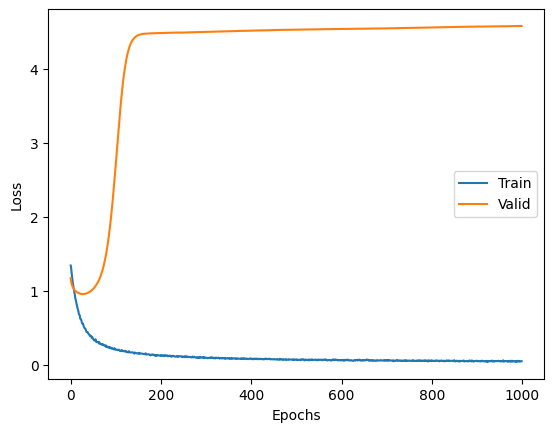

In [8]:
fig, ax = plt.subplots()
ax.plot(log_dict["train_losses"], label="Train")
ax.plot(log_dict["valid_losses"], label="Valid")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

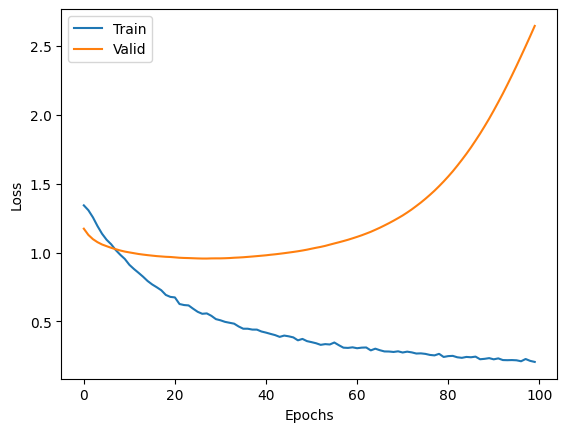

In [9]:
fig, ax = plt.subplots()
ax.plot(log_dict["train_losses"][:100], label="Train")
ax.plot(log_dict["valid_losses"][:100], label="Valid")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

### What bout different L2 regularization params?

In [13]:
weight_decays = np.arange(0, 1.0, 0.2)
log_dicts = []
for weight_decay in weight_decays:
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(feature_dims)}
    trainer = Trainer(learning_rate=0.01, max_iter=1000, batch_size=1000, weight_decay=weight_decay)
    model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, feature_dims)

    time_bin = 0.7
    pseudo_sess = pd.concat(sess_datas.apply(
        lambda x: x.generate_pseudo_data(500, 100, time_bin)
    ).values, ignore_index=True)

    train_data = pseudo_sess[pseudo_sess.Type == "Train"]
    test_data = pseudo_sess[pseudo_sess.Type == "Test"]

    x_train = pseudo_classifier_utils.transform_input_data(train_data)
    y_train = pseudo_classifier_utils.transform_label_data(train_data)

    x_test = pseudo_classifier_utils.transform_input_data(test_data)
    y_test = pseudo_classifier_utils.transform_label_data(test_data)

    print(f"Fitting model with weight decay {weight_decay}")
    log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)
    log_dicts.append(log_dict)

    

cuda
Fitting model with weight decay 0.0
cuda
Fitting model with weight decay 0.2
cuda
Fitting model with weight decay 0.4
cuda
Fitting model with weight decay 0.6000000000000001
cuda
Fitting model with weight decay 0.8


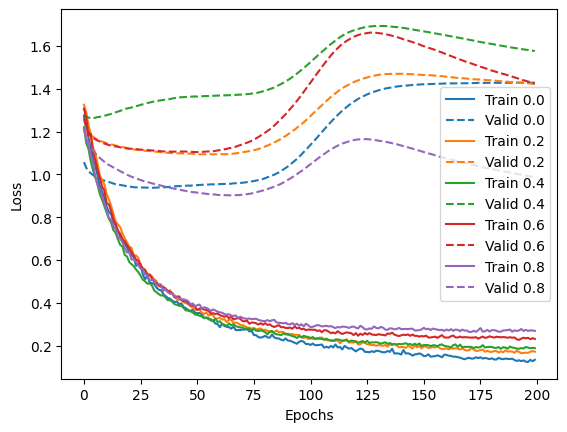

In [14]:
fig, ax = plt.subplots()
for i, weight_decay in enumerate(weight_decays):
    line, = ax.plot(log_dicts[i]["train_losses"][:200], label=f"Train {round(weight_decay, 2)}")
    ax.plot(log_dicts[i]["valid_losses"][:200], label=f"Valid {round(weight_decay, 2)}", color=line.get_color(), linestyle="--")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

### Different time point

In [45]:
weight_decays = np.arange(0, 1.0, 0.2)
log_dicts = []
for weight_decay in weight_decays:
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(feature_dims)}
    trainer = Trainer(learning_rate=0.01, max_iter=1000, batch_size=1000, weight_decay=weight_decay)
    model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, feature_dims)

    time_bin = 1.5
    pseudo_sess = pd.concat(sess_datas.apply(
        lambda x: x.generate_pseudo_data(500, 100, time_bin)
    ).values, ignore_index=True)

    train_data = pseudo_sess[pseudo_sess.Type == "Train"]
    test_data = pseudo_sess[pseudo_sess.Type == "Test"]

    x_train = pseudo_classifier_utils.transform_input_data(train_data)
    y_train = pseudo_classifier_utils.transform_label_data(train_data)

    x_test = pseudo_classifier_utils.transform_input_data(test_data)
    y_test = pseudo_classifier_utils.transform_label_data(test_data)

    print(f"Fitting model with weight decay {weight_decay}")
    log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)
    log_dicts.append(log_dict)

    

cuda


Fitting model with weight decay 0.0
cuda
Fitting model with weight decay 0.2
cuda
Fitting model with weight decay 0.4
cuda
Fitting model with weight decay 0.6000000000000001
cuda
Fitting model with weight decay 0.8


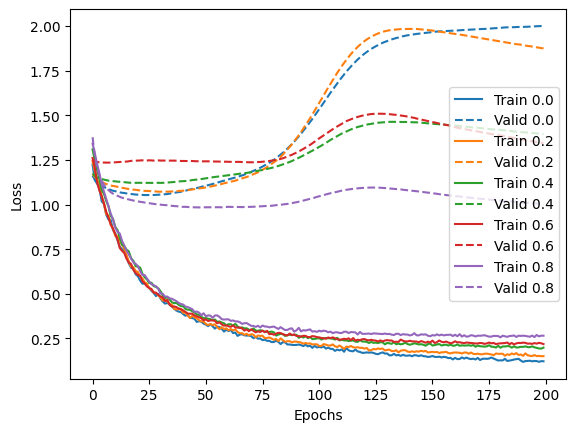

In [47]:
fig, ax = plt.subplots()
for i, weight_decay in enumerate(weight_decays):
    line, = ax.plot(log_dicts[i]["train_losses"][:200], label=f"Train {round(weight_decay, 2)}")
    ax.plot(log_dicts[i]["valid_losses"][:200], label=f"Valid {round(weight_decay, 2)}", color=line.get_color(), linestyle="--")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

### Does nonlinearity help?

In [15]:
sess_datas = valid_sess.apply(lambda x: create_session_data(x.session_name), axis=1)

num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
print(f"{num_neurons} neurons to decode with")
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(feature_dims), "hidden_sizes":[100, 100]}
trainer = Trainer(learning_rate=0.01, max_iter=1000, batch_size=1000)
model = ModelWrapper(NormedDropoutNonlinear, init_params, trainer, feature_dims)

1045 neurons to decode with
cuda


In [16]:
time_bin = 0.7
pseudo_sess = pd.concat(sess_datas.apply(
    lambda x: x.generate_pseudo_data(1000, 200, time_bin)
).values, ignore_index=True)

train_data = pseudo_sess[pseudo_sess.Type == "Train"]
test_data = pseudo_sess[pseudo_sess.Type == "Test"]

x_train = pseudo_classifier_utils.transform_input_data(train_data)
y_train = pseudo_classifier_utils.transform_label_data(train_data)

x_test = pseudo_classifier_utils.transform_input_data(test_data)
y_test = pseudo_classifier_utils.transform_label_data(test_data)

print("Fitting model")
log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)

Fitting model


Text(0, 0.5, 'Loss')

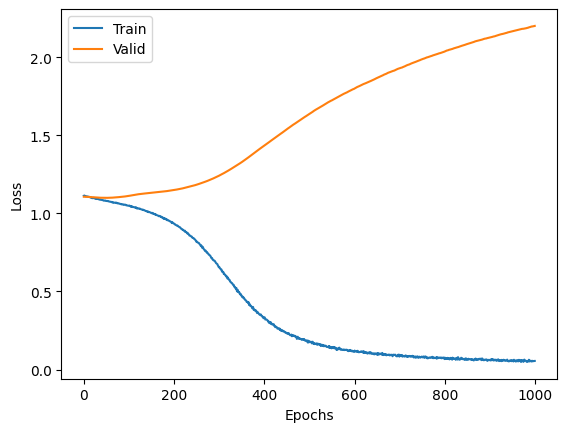

In [17]:
fig, ax = plt.subplots()
ax.plot(log_dict["train_losses"], label="Train")
ax.plot(log_dict["valid_losses"], label="Valid")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

### Try some hyperparam tuning for non-linear layers

In [18]:
weight_decays = np.arange(0, 1.0, 0.2)
log_dicts = []
for weight_decay in weight_decays:
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(feature_dims), "hidden_sizes":[100, 100]}
    trainer = Trainer(learning_rate=0.01, max_iter=10000, batch_size=1000, weight_decay=weight_decay)
    model = ModelWrapper(NormedDropoutNonlinear, init_params, trainer, feature_dims)
    time_bin = 0.7
    pseudo_sess = pd.concat(sess_datas.apply(
        lambda x: x.generate_pseudo_data(500, 100, time_bin)
    ).values, ignore_index=True)

    train_data = pseudo_sess[pseudo_sess.Type == "Train"]
    test_data = pseudo_sess[pseudo_sess.Type == "Test"]

    x_train = pseudo_classifier_utils.transform_input_data(train_data)
    y_train = pseudo_classifier_utils.transform_label_data(train_data)

    x_test = pseudo_classifier_utils.transform_input_data(test_data)
    y_test = pseudo_classifier_utils.transform_label_data(test_data)

    print(f"Fitting model with weight decay {weight_decay}")
    log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)
    log_dicts.append(log_dict)

cuda
Fitting model with weight decay 0.0
cuda
Fitting model with weight decay 0.2
cuda
Fitting model with weight decay 0.4
cuda
Fitting model with weight decay 0.6000000000000001
cuda
Fitting model with weight decay 0.8


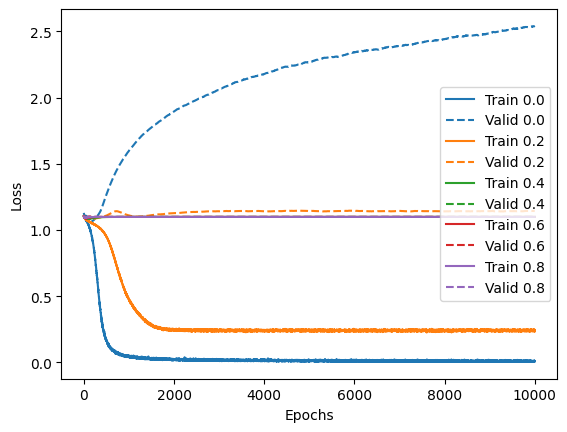

In [19]:
fig, ax = plt.subplots()
for i, weight_decay in enumerate(weight_decays):
    line, = ax.plot(log_dicts[i]["train_losses"], label=f"Train {round(weight_decay, 2)}")
    ax.plot(log_dicts[i]["valid_losses"], label=f"Valid {round(weight_decay, 2)}", color=line.get_color(), linestyle="--")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

## Rule dim decoding after some hyperparam tuning?

Text(0, 0.5, 'Decoder Accuracy')

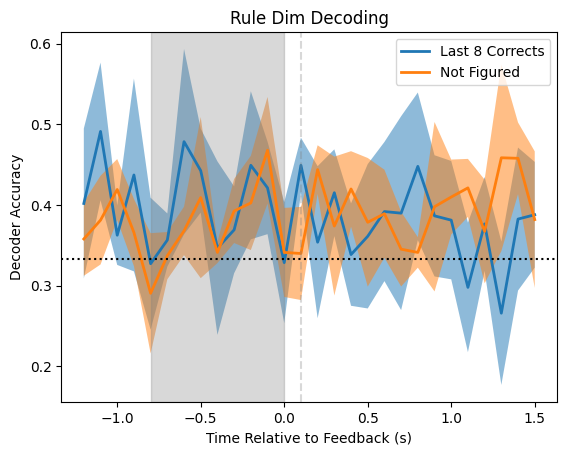

In [49]:
fig, ax = plt.subplots()

pseudo_test = np.load(f"/data/patrick_scratch/pseudo/rule_dim_tuned_last_cors_test_accs.npy")
pseudo_not_figured = np.load(f"/data/patrick_scratch/pseudo/rule_dim_tuned_not_figured_test_accs.npy")

visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_test,
    1.3, 1.5, 0.1,
    ax,
    label=f"Last 8 Corrects",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_not_figured,
    1.3, 1.5, 0.1,
    ax,
    label=f"Not Figured",
    right_align=True, 
)

ax.legend()
ax.set_title(f"Rule Dim Decoding")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.333, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

## Rule dim decoding, same hyperparams, if its just cor/inc?

Text(0, 0.5, 'Decoder Accuracy')

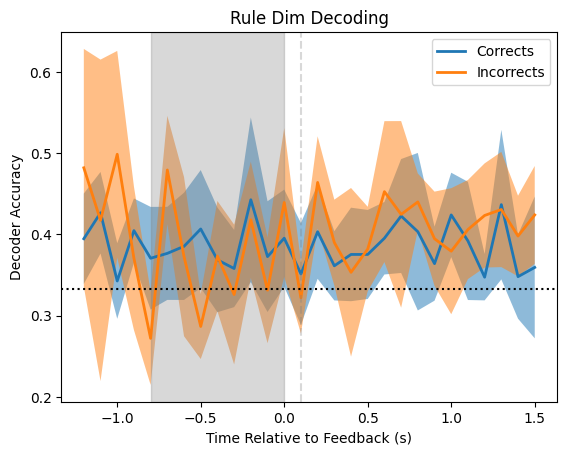

In [50]:
fig, ax = plt.subplots()

pseudo_test = np.load(f"/data/patrick_scratch/pseudo/rule_dim_tuned_cor_test_accs.npy")
pseudo_not_figured = np.load(f"/data/patrick_scratch/pseudo/rule_dim_tuned_inc_test_accs.npy")

visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_test,
    1.3, 1.5, 0.1,
    ax,
    label=f"Corrects",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_not_figured,
    1.3, 1.5, 0.1,
    ax,
    label=f"Incorrects",
    right_align=True, 
)

ax.legend()
ax.set_title(f"Rule Dim Decoding")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.333, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

## What's this look like for a decoding that works? (Feature decoding)

In [26]:
feature_dims = ["Color", "Shape", "Pattern"]
possible_features = {
    "Color": ['CYAN', 'GREEN', 'MAGENTA', 'YELLOW'],
    "Shape": ['CIRCLE', 'SQUARE', 'STAR', 'TRIANGLE'],
    "Pattern": ['ESCHER', 'POLKADOT', 'RIPPLE', 'SWIRL']
}
valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions.pickle")

feature_dim = "Shape"

sess_datas = valid_sess.apply(lambda x: SessionData.load_session_data(x.session_name, feature_dim), axis=1)
classes = possible_features[feature_dim]
num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.05, max_iter=1000, batch_size=1000)
model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

time_bin = 0.7


cpu


In [27]:
pseudo_sess = pd.concat(sess_datas.apply(
    lambda x: x.generate_pseudo_data(1000, 200, time_bin)
).values, ignore_index=True)

train_data = pseudo_sess[pseudo_sess.Type == "Train"]
test_data = pseudo_sess[pseudo_sess.Type == "Test"]

x_train = pseudo_classifier_utils.transform_input_data(train_data)
y_train = pseudo_classifier_utils.transform_label_data(train_data)

x_test = pseudo_classifier_utils.transform_input_data(test_data)
y_test = pseudo_classifier_utils.transform_label_data(test_data)

print("Fitting model")
log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)

Fitting model


Text(0, 0.5, 'Loss')

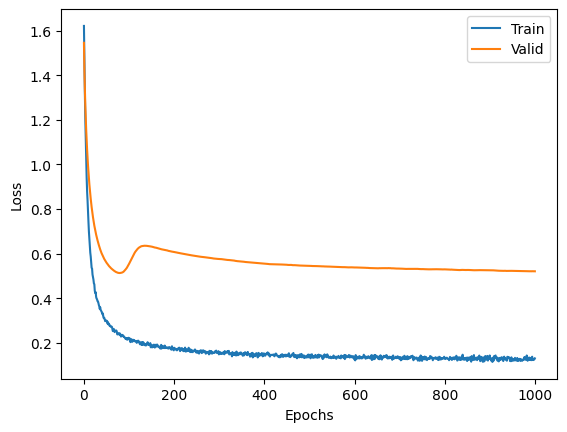

In [28]:
fig, ax = plt.subplots()
ax.plot(log_dict["train_losses"], label="Train")
ax.plot(log_dict["valid_losses"], label="Valid")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")